<h2 style="color: #F08B51;">Digit Recognizer</h2>

<img src= "dr.png" width="500"/>

<h2 style="color: #F08B51;">Introduction</h2>

This project aims to build a simple machine learning model to recognize handwritten digits using the MNIST dataset.

<h2 style="color: #F08B51;">Requirements</h2>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from datetime import datetime
date_str = datetime.now().strftime("%Y%m%d_%H%M%S")


<h2 style="color: #F08B51;">Import Data</h2>

In [8]:
df_train = pd.read_csv("train.csv")


In [9]:
df_test = pd.read_csv("test.csv")

EDA (Exploratory Data Analysis)

In [11]:
df_train.sample(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
3133,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38156,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20553,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_test.sample(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
21277,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df_train["label"].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [14]:
df_train.isnull().sum().sum()

0

In [15]:
df_test.isnull().sum().sum()

0

In [16]:
df_train.shape

(42000, 785)

In [17]:
df_test.shape

(28000, 784)

<h2 style="color: #F08B51;">Data Visualization</h2>

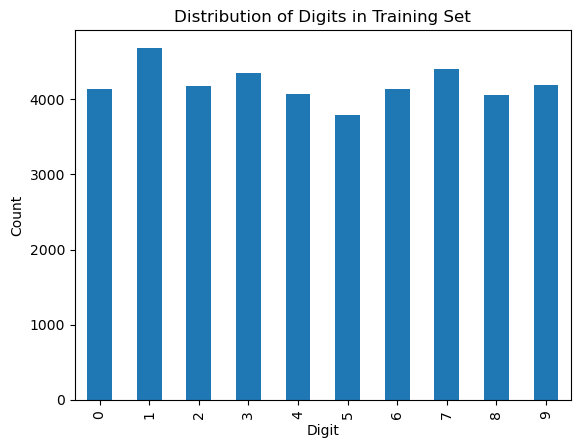

In [19]:
df_train["label"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Distribution of Digits in Training Set")
plt.show()

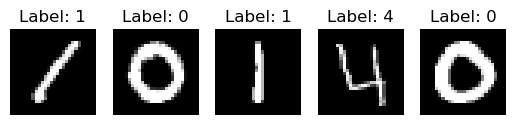

In [20]:
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(df_train.drop("label", axis=1).iloc[i].values.reshape(28,28), cmap="gray")
    plt.title(f"Label: {df_train['label'].iloc[i]}")
    plt.axis("off")
plt.show()

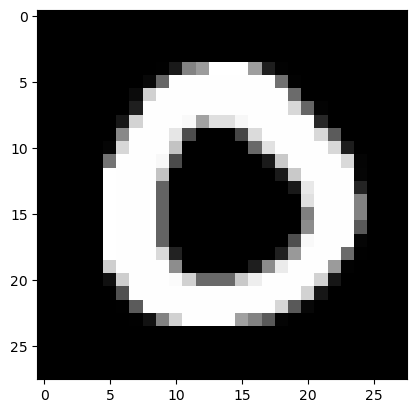

In [21]:
plt.imshow(df_train.drop("label", axis=1).iloc[i].values.reshape(28,28), cmap="gray")


<h2 style="color: #F08B51;">Preprocessing</h2> 

In [23]:
x_train = df_train.drop("label", axis=1).values
y_train = df_train["label"].values

In [24]:
x_test = df_test.values

In [25]:
x_train.shape, y_train.shape, x_test.shape

((42000, 784), (42000,), (28000, 784))

In [26]:
preprocessing_layer = tf.keras.Sequential([
    tf.keras.Input(shape=(784,)),
    tf.keras.layers.Reshape((28, 28, 1)),       # Reshape to 28x28 grayscale image
    tf.keras.layers.Rescaling(1./255)           # Normalize pixel values
])

<h2 style="color: #F08B51;">Requirements</h2> Model Configuration

In [28]:
SEED = 42
NUM_FOLD = 5
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
PREFETCH_SIZE = tf.data.AUTOTUNE

kf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=SEED)

fold_acc_hist, fold_loss_hist = [], []
histories = []

<h2 style="color: #F08B51;">Requirements</h2> CNN Model Architecture

In [30]:
def build_digit_model(input_size=(28, 28, 1), num_classes=10):
    inputs = tf.keras.Input(shape=input_size)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)
    return model


<h2 style="color: #F08B51;"> Model Training with Stratified K-Fold</h2>

In [32]:
for fold, (train_idx, val_idx) in enumerate(kf.split(x_train, y_train)):
    print(f"Fold {fold+1}/{NUM_FOLD}")

    # Split data into training and validation sets
    x_tr, x_val = x_train[train_idx], x_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Convert to TensorFlow datasets
    tr_ds = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    # Optimize datasets with shuffle, batch, map (preprocessing), and prefetch
    tr_ds = (tr_ds.shuffle(SHUFFLE_SIZE)
                  .batch(BATCH_SIZE)
                  .map(lambda x, y: (preprocessing_layer(x), y))
                  .prefetch(PREFETCH_SIZE))

    val_ds = (val_ds.batch(BATCH_SIZE)
                    .map(lambda x, y: (preprocessing_layer(x), y))
                    .prefetch(PREFETCH_SIZE))

    # Build and compile model
    model = build_digit_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Define callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, min_lr=1e-5)

    # Train model
    history = model.fit(
        tr_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[early_stop, reduce_lr],
        verbose=2
    )

    # Save metrics
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    fold_acc_hist.append(val_acc)
    fold_loss_hist.append(val_loss)
    histories.append(history.history)

    print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

Fold 1/5
Epoch 1/30
1050/1050 - 31s - 29ms/step - accuracy: 0.9376 - loss: 0.2118 - val_accuracy: 0.9650 - val_loss: 0.1169 - learning_rate: 0.0010
Epoch 2/30
1050/1050 - 43s - 41ms/step - accuracy: 0.9793 - loss: 0.0685 - val_accuracy: 0.9771 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 3/30
1050/1050 - 39s - 37ms/step - accuracy: 0.9870 - loss: 0.0416 - val_accuracy: 0.9790 - val_loss: 0.0645 - learning_rate: 0.0010
Epoch 4/30
1050/1050 - 40s - 38ms/step - accuracy: 0.9920 - loss: 0.0260 - val_accuracy: 0.9785 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 5/30
1050/1050 - 27s - 26ms/step - accuracy: 0.9945 - loss: 0.0181 - val_accuracy: 0.9771 - val_loss: 0.0780 - learning_rate: 0.0010
Epoch 6/30
1050/1050 - 43s - 41ms/step - accuracy: 0.9962 - loss: 0.0122 - val_accuracy: 0.9839 - val_loss: 0.0645 - learning_rate: 0.0010
Epoch 7/30
1050/1050 - 69s - 66ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9858 - val_loss: 0.0590 - learning_rate: 2.0000e-04
Epoch 8/30
105

Model Performance Evaluation

In [34]:
average_accuracy = np.mean(fold_acc_hist)
average_loss = np.mean(fold_loss_hist)

print(f"Average Validation Accuracy: {average_accuracy:.4f}")
print(f"Average Validation Loss: {average_loss:.4f}")

Average Validation Accuracy: 0.9859
Average Validation Loss: 0.0577


<h2 style="color: #F08B51;">Visualizing Metrics Across All Folds</h2> 

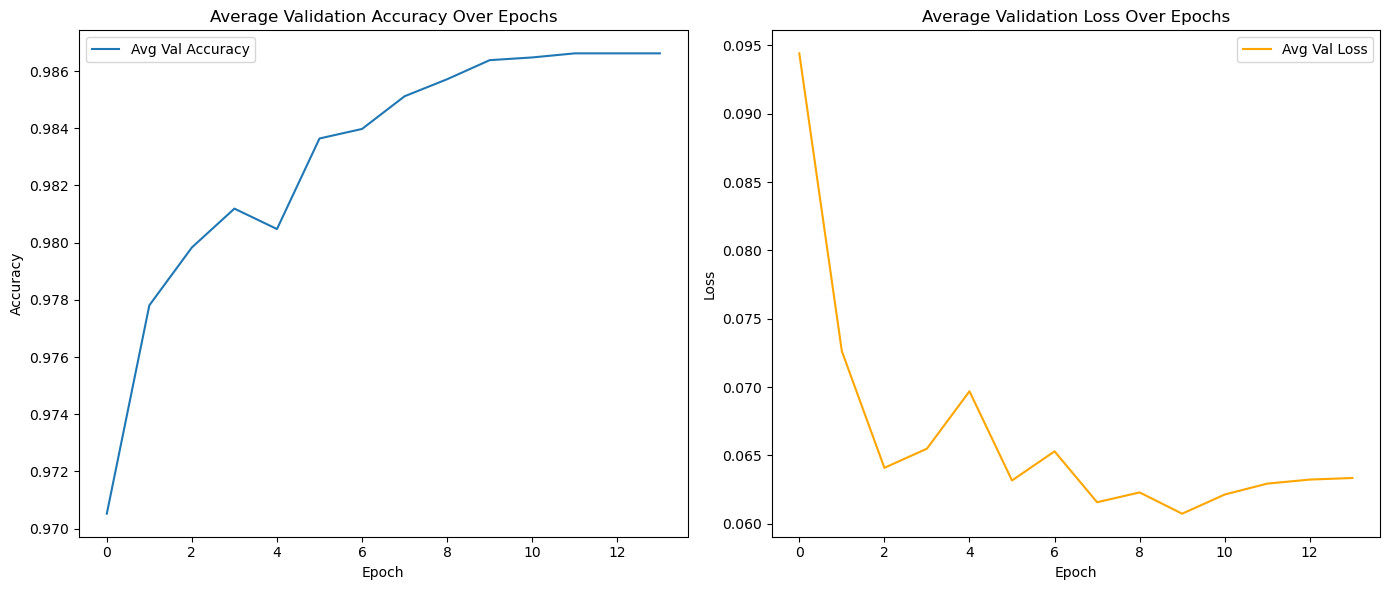

In [36]:
all_fold_acc = [hist["val_accuracy"] for hist in histories]
all_fold_loss = [hist["val_loss"] for hist in histories]

max_epochs = max(len(h) for h in all_fold_acc)

def pad_history(hist_list):
    return [h + [h[-1]] * (max_epochs - len(h)) for h in hist_list]

acc_array = np.array(pad_history(all_fold_acc))
loss_array = np.array(pad_history(all_fold_loss))

mean_acc = acc_array.mean(axis=0)
mean_loss = loss_array.mean(axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(mean_acc, label="Avg Val Accuracy")
ax1.set_title("Average Validation Accuracy Over Epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()

ax2.plot(mean_loss, label="Avg Val Loss", color="orange")
ax2.set_title("Average Validation Loss Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.tight_layout()
plt.show()

<h2 style="color: #F08B51;">Test Set Prediction Preparation</h2> 

In [38]:
test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = (
    test_ds
    .batch(BATCH_SIZE)
    .map(lambda x: preprocessing_layer(x))
    .prefetch(tf.data.AUTOTUNE)
)

Making Predictions

In [40]:
pred_logits = model.predict(test_ds)
pred_labels = tf.argmax(pred_logits, axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


Class Distribution in Prediction

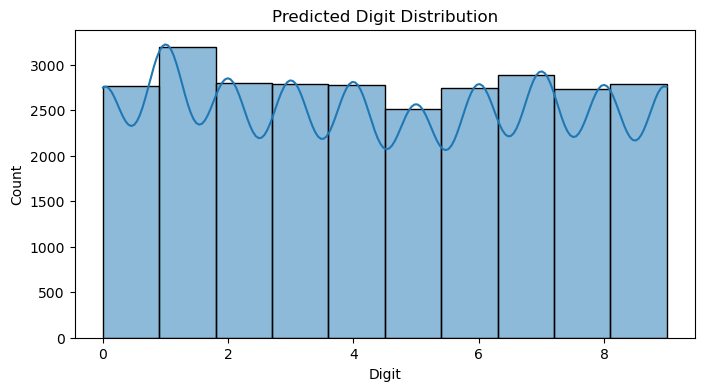

In [42]:
plt.figure(figsize=(8, 4))
sns.histplot(pred_labels.numpy(), bins=10, kde=True)
plt.title("Predicted Digit Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

<h2 style="color: #F08B51;">Saving Submission File</h2> 

In [44]:
# Prepare submission DataFrame with image indices and predicted labels
submission = pd.DataFrame(
    {'ImageId': df_test.index + 1,  # Kaggle requires 1-based index usually
     'Label': pred_labels.numpy()}
)

In [45]:
# Save the submission DataFrame to a CSV file (without the index)
submission.to_csv('submission.csv', index=False)

# (Optional) Print a confirmation message
print("Submission file 'submission.csv' has been created successfully!")

# (Optional) Show the first few rows of the submission to verify
print(submission.head())

Submission file 'submission.csv' has been created successfully!
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
